# Least-squares fitting to estimate 3D rotation vector from 2D images 

This script estimates the rotational axis, for solid body rotation about an aribtrary axis in 3D, that gives rise to an observed displacement field computed from 2D images.  

Input list of point locations and displacement fields:
{(r_x, r_z)}_i for i in N

Params: (w_x, w_y, w_z)



In [261]:
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib notebook

# Load the data
# folder = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_2020-12-08 01-35'

# folder = 'H:/2019 Monterey Trip/Vorticella_GM/2019_08_22/track10'

folder = 'D:/Vorticella_GravityMachine/SphereRotation_analysis'
track_folder = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalAnalysis/FeatureTracks_Final'

# track_folder = 'RotationAnalysisTracks'
a, test_image_folder = os.path.split(folder)
print(test_image_folder)

file = 'Sphere007_367_383.csv'

# R = 448/2.0 # Aggregate size for test images

pixelpermm = 449 # 4x objective

# sphere_size_file = os.path.join(folder, 'orgDims.csv')

# if(os.path.exists(sphere_size_file)):
#     df_size = pd.read_csv(sphere_size_file)
#     R_mm = df_size['OrgDim'][0]/2.0

# else:
#     raise

df = pd.read_csv(os.path.join(folder, track_folder, file))

# R_mm = 1.066/2.0
R = int(df['object diameter (px)'][0]/2)
print('radius of aggregate in pixels: {}'.format(R))

nTracks = int(max(df['feature ID']+1))

print('No:of features tracked: {}'.format(nTracks))

nTimepoints = int(len(df['Time'])/nTracks)
print(nTimepoints)

# generate a dict containing time series for each track
df_tracks = {ii : df.loc[df['feature ID']==ii] for ii in range(nTracks)}

df_tracks

# time_vect = np.array(range(nTimepoints))



print(time_vect)



SphereRotation_analysis
radius of aggregate in pixels: 281
No:of features tracked: 3
67
[367.3  367.55 367.84 368.07 368.32 368.55 368.81 369.04 369.28 369.52
 369.8  370.07 370.34 370.65 370.89 371.12 371.37 371.61 371.87 372.13
 372.38 372.64 372.87 373.11 373.38 373.63 373.88 374.15 374.38 374.63
 374.88 375.08 375.32 375.58 375.87 376.13 376.36 376.64 376.88 377.11
 377.37 377.63 377.88 378.14 378.36 378.57 378.85 379.12 379.37 379.65
 379.9  380.15 380.41 380.64 380.89 381.16 381.4  381.62 381.84 382.07
 382.33 382.57 382.82 383.09 383.34 383.58 383.83]


In [414]:
# Load the actual rotation parameters for the test images
df_rotation = pd.read_csv(os.path.join(folder, 'RotationParameters.csv'))

omega_true = df_rotation['Omega'][0]
p_x_true, p_y_true, p_z_true = df_rotation['p_x'][0], df_rotation['p_y'][0], df_rotation['p_z'][0]

orient_vect_true = np.array([p_x_true, p_y_true, p_z_true])

omega_vect_true = omega_true*orient_vect_true

print(omega_true)
print(p_x_true, p_y_true, p_z_true)

0.01
0.0 0.1961161494255066 0.9805806875228882


# Filter the data to remove pixel-shift noise from the tracker

In [262]:
# Time windows for smoothing and velocity estimation
# window_size = 2 # should be even
# Choose a window-size based on a time-interval 
time_window = 3 # Time window over which we calculate the velocity in seconds

delta_t_avg = np.nanmean(time_vect[1:]-time_vect[:-1])

print('Mean time interval: {} s'.format(delta_t_avg))

window_size = int(time_window/delta_t_avg)

# make the window-size an even integer
if window_size%2 !=0:
    window_size+=1
    
print('Chosen window size for velocity calculation: {}'.format(window_size))

sphere_centroid_X_filtered = None
sphere_centroid_Z_filtered = None

feature_centroid_X_filtered = {}
feature_centroid_Z_filtered = {}

for ii in range(nTracks):
    
    sphere_centroid_X_filtered = np.array(df_tracks[ii].loc[:,'sphere centroid X'].rolling(window = window_size, center = True).mean())
    sphere_centroid_Z_filtered = np.array(df_tracks[ii].loc[:,'sphere centroid Z'].rolling(window = window_size, center = True).mean())
    
    feature_centroid_X_filtered[ii] = np.array(df_tracks[ii].loc[:,'feature centroid X'].rolling(window = window_size, center = True).mean())
    feature_centroid_Z_filtered[ii] = np.array(df_tracks[ii].loc[:,'feature centroid Z'].rolling(window = window_size, center = True).mean())
#     df_tracks[ii]['feature centroid X'] = df_tracks[ii]['feature centroid X'].rolling(window = window_size).mean()
#     df_tracks[ii]['feature centroid Z'] = df_tracks[ii]['feature centroid Z'].rolling(window = window_size).mean()

nan_mask = np.logical_not(np.isnan(sphere_centroid_X_filtered))



print(nan_mask)


Mean time interval: 0.25045454545454504 s
Chosen window size for velocity calculation: 12
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False]


# Allocate arrays to store the object and feature tracks

In [263]:
image_centroids_x = {}
image_centroids_z = {}
centroids_x = {}
centroids_z = {}

# Choose a subset of the time-vect excluding the nan values
time_vect = time_vect[nan_mask]
nTimepoints = len(time_vect)

# Sphere centroid common to all tracks
sphere_centroids_x, sphere_centroids_z = sphere_centroid_X_filtered[nan_mask], sphere_centroid_Z_filtered[nan_mask]

for ii in range(nTracks):
    image_centroids_x[ii], image_centroids_z[ii] = feature_centroid_X_filtered[ii][nan_mask], feature_centroid_Z_filtered[ii][nan_mask]
   
print(time_vect)

[368.81 369.04 369.28 369.52 369.8  370.07 370.34 370.65 370.89 371.12
 371.37 371.61 371.87 372.13 372.38 372.64 372.87 373.11 373.38 373.63
 373.88 374.15 374.38 374.63 374.88 375.08 375.32 375.58 375.87 376.13
 376.36 376.64 376.88 377.11 377.37 377.63 377.88 378.14 378.36 378.57
 378.85 379.12 379.37 379.65 379.9  380.15 380.41 380.64 380.89 381.16
 381.4  381.62 381.84 382.07 382.33 382.57]


In [264]:
# Get the centroid locations relative to the sphere center
for ii in range(nTracks):
    centroids_x[ii] = image_centroids_x[ii] - sphere_centroids_x
    centroids_z[ii] = image_centroids_z[ii] - sphere_centroids_z

    print(len(centroids_x[ii]))

56
56
56


<IPython.core.display.Javascript object>


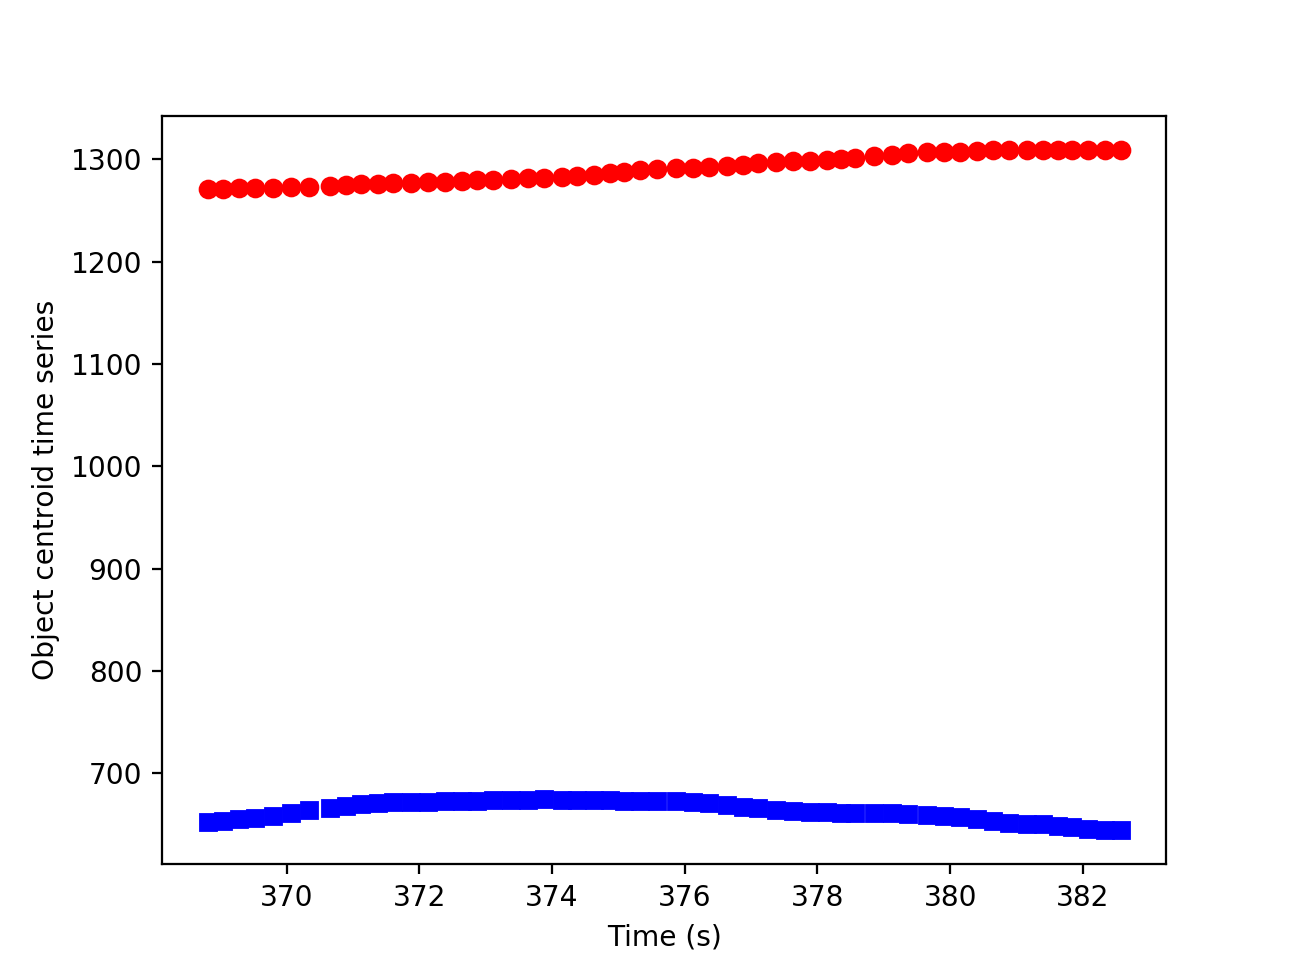

<IPython.core.display.Javascript object>


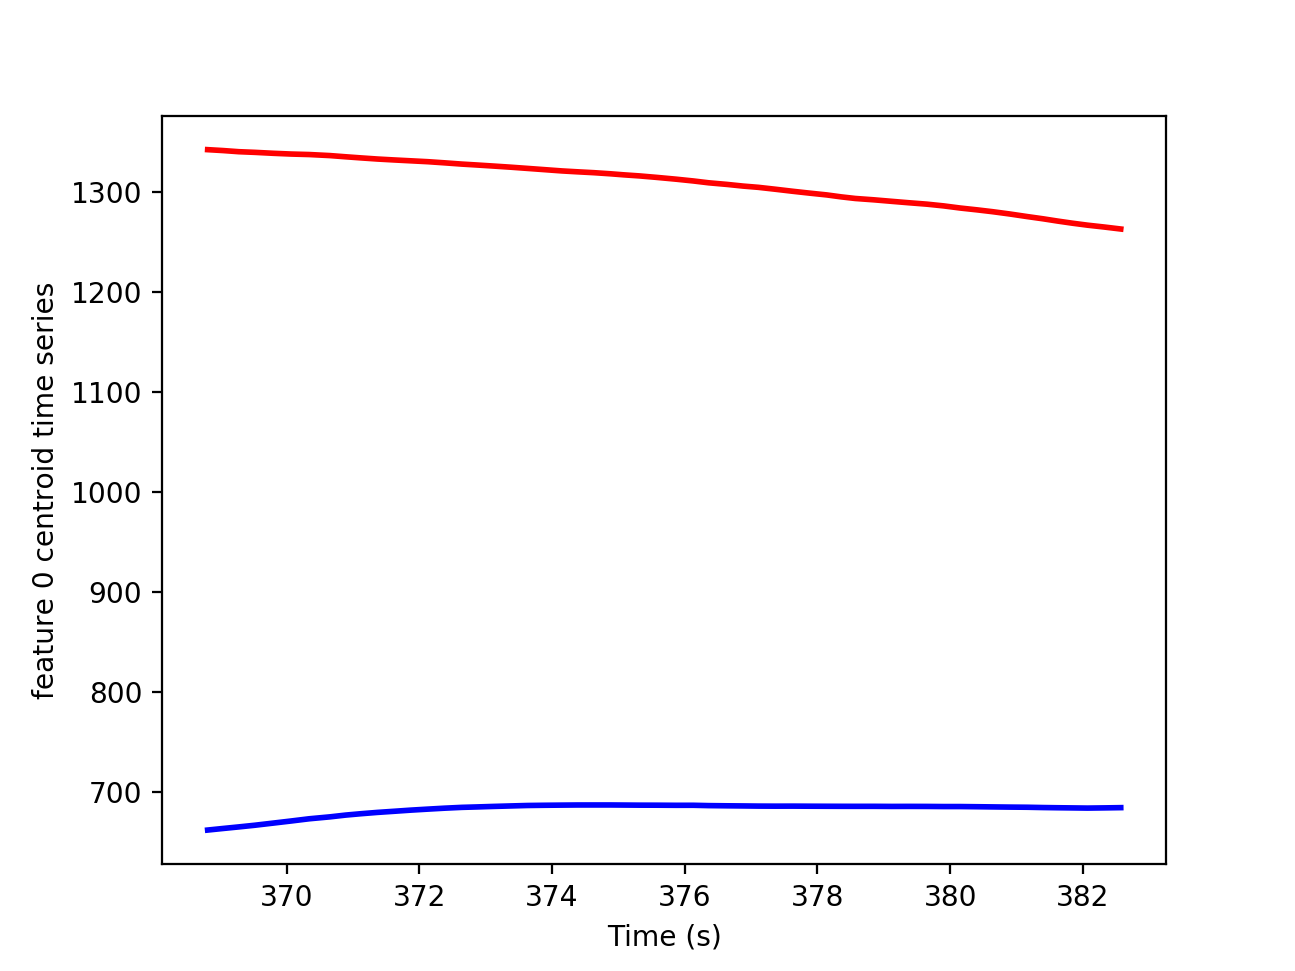

<IPython.core.display.Javascript object>


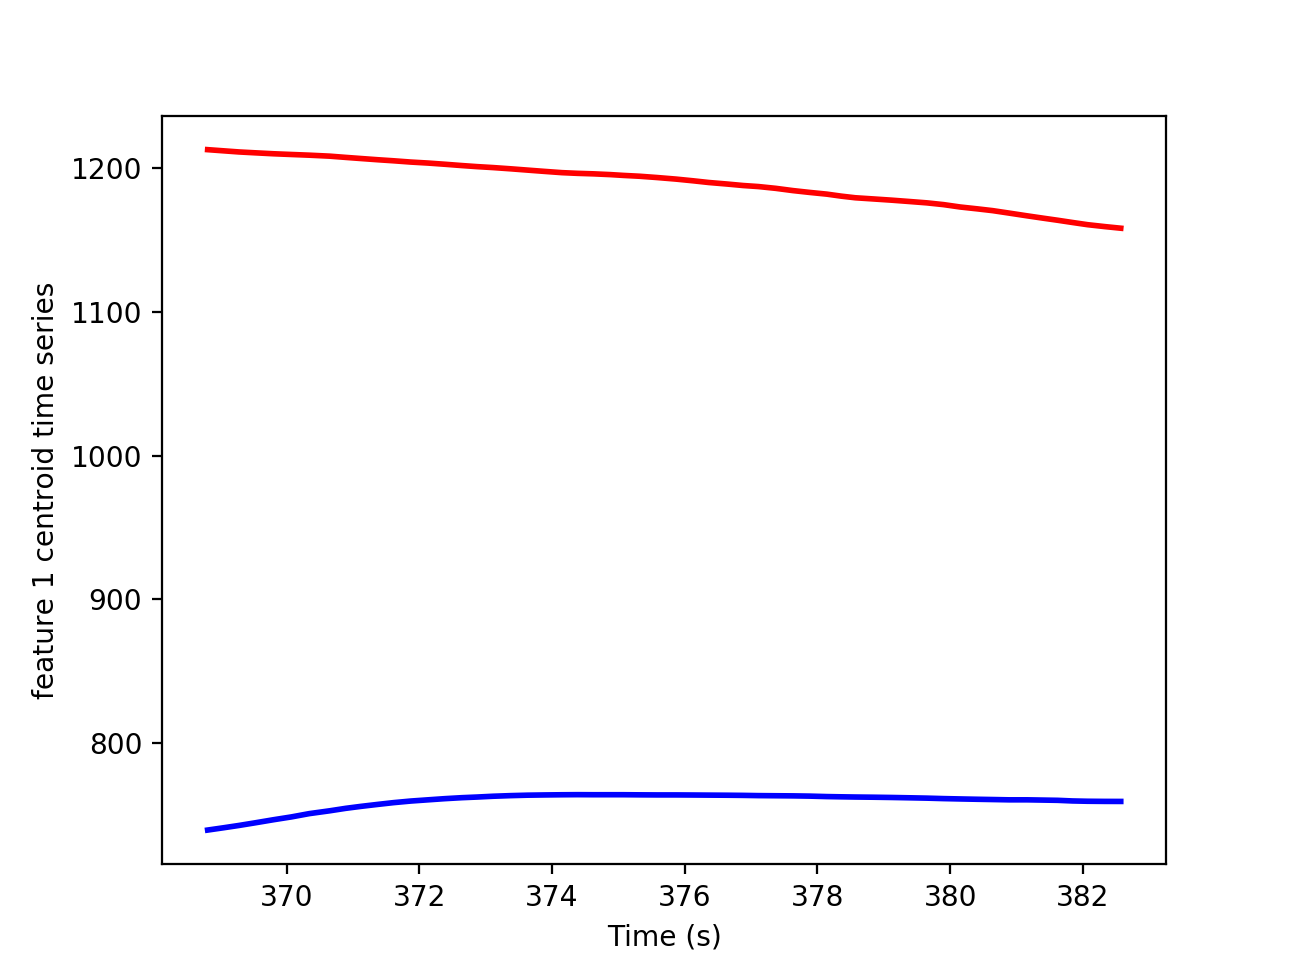

<IPython.core.display.Javascript object>


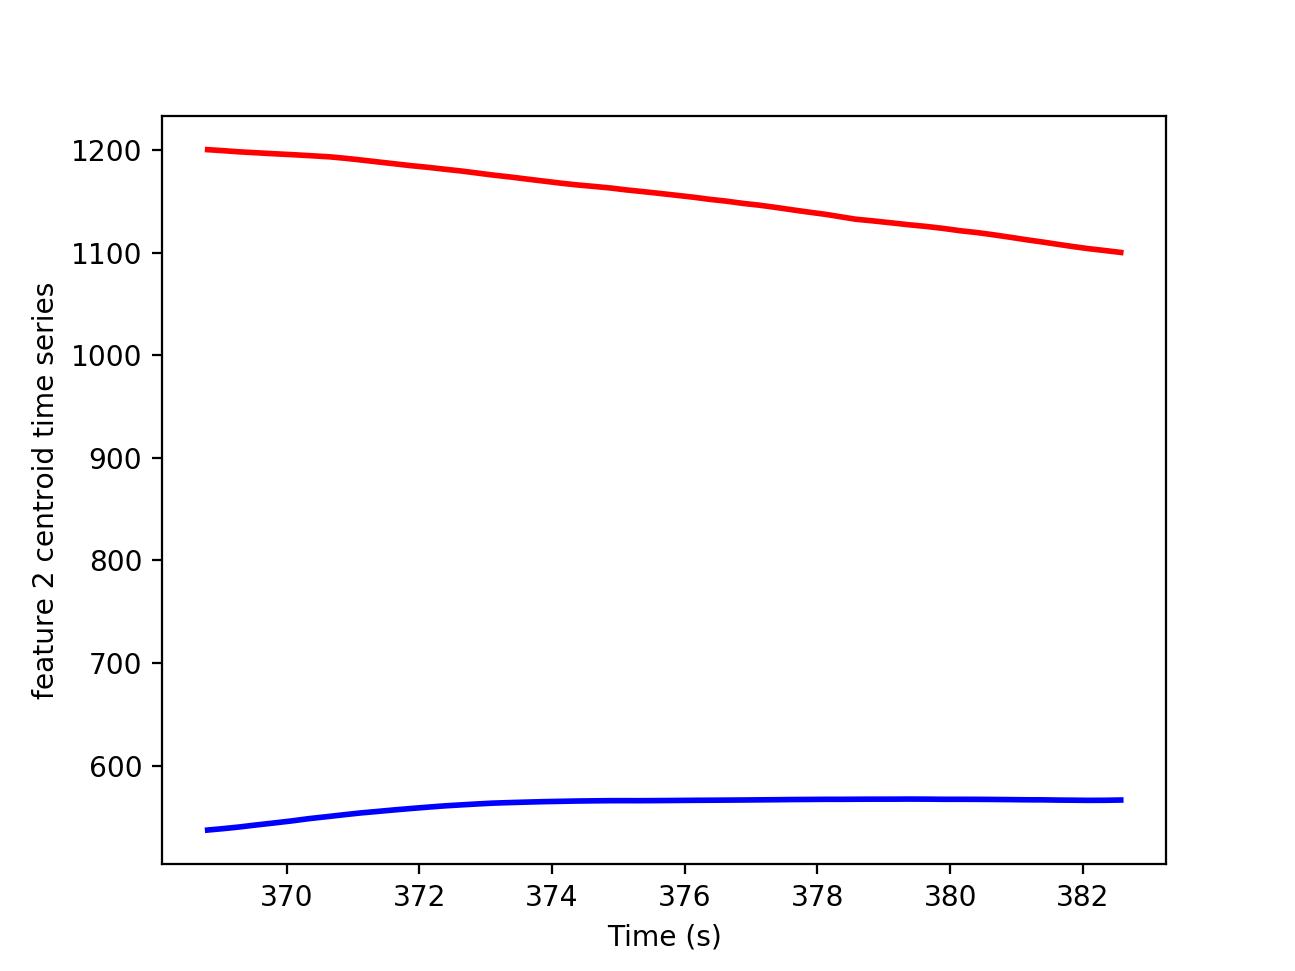

In [265]:
# Plot the centroid location tracks for the features and object


plt.figure()
plt.plot(time_vect, sphere_centroids_x, 'ro', linewidth = 2, label = 'sphere centroid x')
plt.plot(time_vect, sphere_centroids_z, 'bs', linewidth = 2, label = 'sphere centroid z')
plt.xlabel('Time (s)')
plt.ylabel('Object centroid time series')
plt.show()



for ii in range(nTracks):
    plt.figure()
    plt.plot(time_vect, image_centroids_x[ii], 'r-', linewidth = 2, label = 'feature centroid x')
    plt.plot(time_vect, image_centroids_z[ii], 'b-', linewidth = 2, label = 'feature centroid z')
    plt.xlabel('Time (s)')
    plt.ylabel('feature {} centroid time series'.format(ii))
    plt.show()
    
# Plots of the final object centroids

#     plt.figure()
#     plt.plot(time_vect, centroids_x[ii], 'r-', linewidth = 2, label = 'sphere centroid x')
#     plt.plot(time_vect, centroids_z[ii], 'b-', linewidth = 2, label = 'sphere centroid z')
#     plt.xlabel('Time (s)')
#     plt.ylabel('feature {} centroid time series'.format(ii))
#     plt.show()

In [266]:
# Calculate centroid velocity over a suitable time-window for each track


overlap = int(window_size/2)  # Max overlap = window_size -1
window_centers = np.array(range(int(window_size/2), nTimepoints-int(window_size/2), window_size - overlap))
nWindows = len(window_centers) # No:of time-windows over the entire track

window_edges = [[window_centers[ii] - int(window_size/2), window_centers[ii] + int(window_size/2)] for ii in range(nWindows)]
print(window_centers)
print(window_edges)

centroids_velocity_x = {ii: np.zeros(nWindows) for ii in range(nTracks)}
centroids_velocity_z = {ii: np.zeros(nWindows) for ii in range(nTracks)}
positions_center_x = {ii:np.zeros(nWindows) for ii in range(nTracks)} # Position of the features at the mid-point of the time-windows
positions_center_y = {ii:np.zeros(nWindows) for ii in range(nTracks)} # Position of the features at the mid-point of the time-windows
positions_center_z = {ii:np.zeros(nWindows) for ii in range(nTracks)} # # Position of the features at the mid-point of the time-windows

# Estimate the velocity of feature centroids (linear fit over the specified time window)
for index, center in enumerate(window_centers):
    
    # Create a sub-portion of the track containing N points
    for ii in range(nTracks):
        centroids_x_slice = centroids_x[ii][window_edges[index][0]:window_edges[index][1]]
        centroids_z_slice = centroids_z[ii][window_edges[index][0]:window_edges[index][1]]
        time_vect_slice = time_vect[window_edges[index][0]:window_edges[index][1]]

        poly_x = np.polyfit(time_vect_slice, centroids_x_slice, deg = 1)
        poly_z = np.polyfit(time_vect_slice, centroids_z_slice, deg = 1)

     

        centroids_velocity_x[ii][index] = poly_x[0]
        centroids_velocity_z[ii][index] = poly_z[0]
        
        positions_center_x[ii][index] = centroids_x[ii][center]
        positions_center_z[ii][index] = centroids_z[ii][center]
        positions_center_y[ii][index] = (R**2 - centroids_x[ii][center]**2 + centroids_z[ii][center]**2)**(1/2)
        
        # Calculate the tru translational velocities based on the known angular velocity
        r_init = np.array([positions_center_x[ii][index], positions_center_y[ii][index], positions_center_z[ii][index]])
        

[ 6 12 18 24 30 36 42 48]
[[0, 12], [6, 18], [12, 24], [18, 30], [24, 36], [30, 42], [36, 48], [42, 54]]


<IPython.core.display.Javascript object>


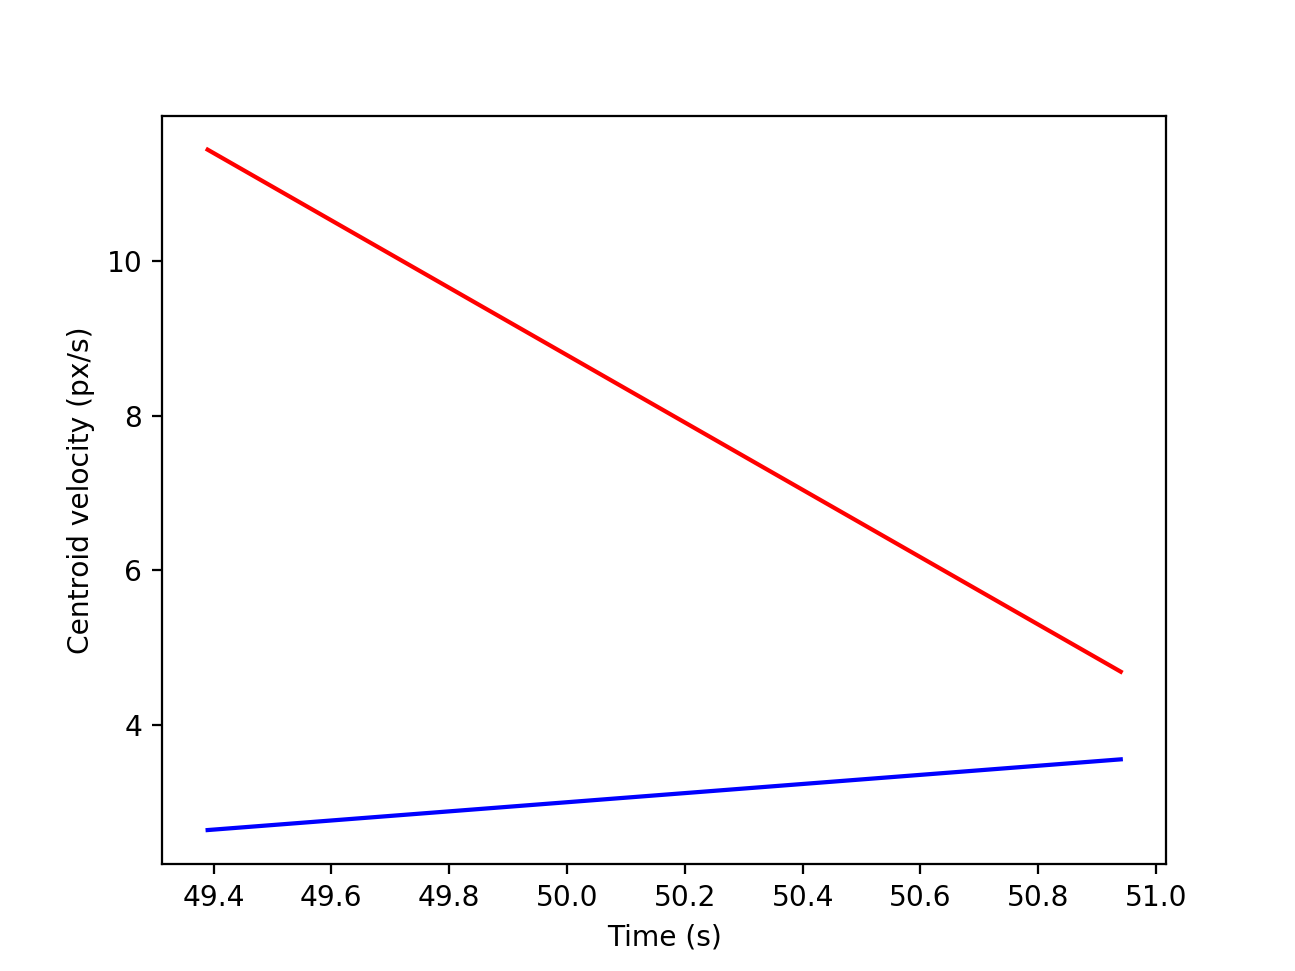

<IPython.core.display.Javascript object>


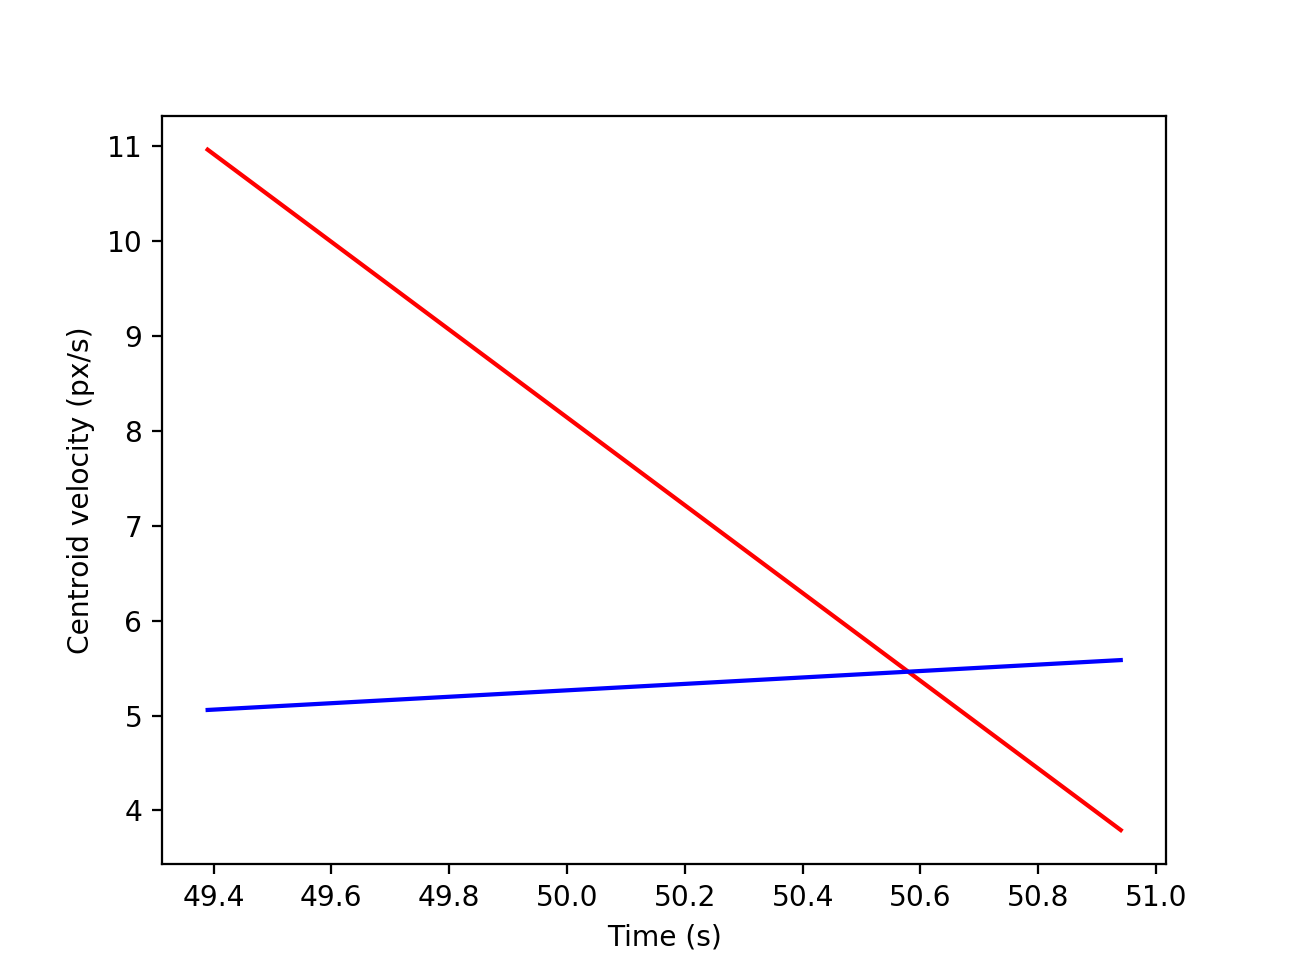

<IPython.core.display.Javascript object>


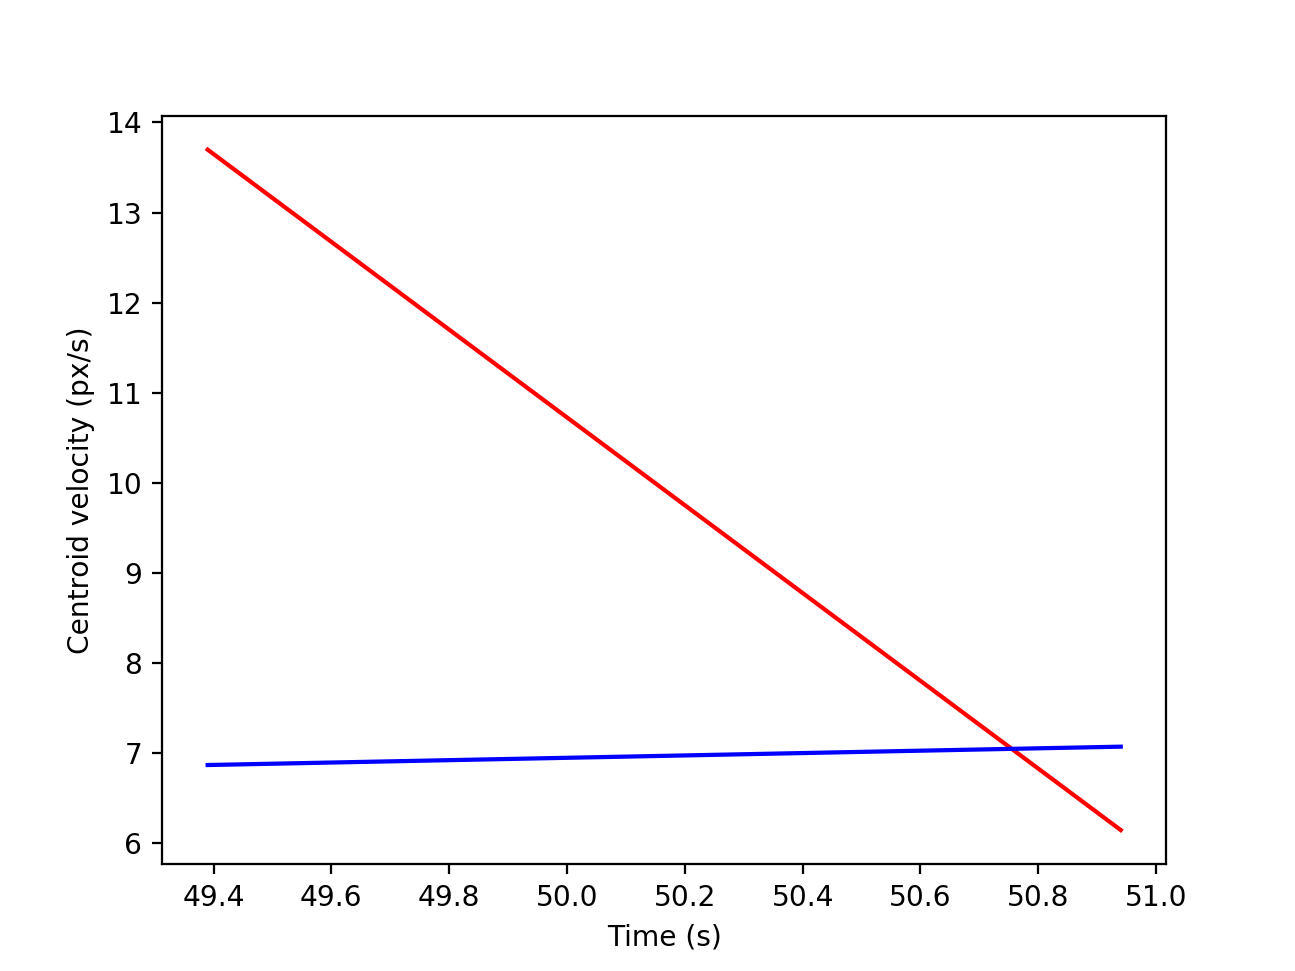

In [258]:
# Plot the time series of velocity of the points

for ii in range(nTracks):
    
   
    plt.figure()
    plt.plot(time_vect[window_centers], centroids_velocity_x[ii], 'r-', label = 'Centroid velocity x')
    plt.plot(time_vect[window_centers], centroids_velocity_z[ii], 'b-', label = 'Centroid velocity z')
    plt.xlabel('Time (s)')
    plt.ylabel('Centroid velocity (px/s)')
    plt.show()

# Velocity-based fitting

In [267]:
angular_velocity_fit = np.zeros((3, nWindows))
angular_velocity_fit_mag = np.zeros(nWindows)

for index in range(nWindows):
    
    # For each time instant build the matrix A and the data vector by looping over all the tracks
    matrix_A = np.zeros((2*nTracks, 3))
    data_vector_fit = np.zeros(2*nTracks)
    
    for ii in range(nTracks):
        r_x, r_y, r_z = positions_center_x[ii][index], positions_center_y[ii][index], positions_center_z[ii][index]

        matrix_A[2*ii,:] = [0, r_z, -r_y]
        matrix_A[2*ii +1, :] = [r_y, -r_x, 0]

        data_vector_fit[2*ii] = centroids_velocity_x[ii][index]
        data_vector_fit[2*ii+1] = centroids_velocity_z[ii][index]

#     print(matrix_A)
#     print(data_vector_fit)
    # Compute the least-squares solution using lin alg

    angular_velocity_fit[:, index] = np.matmul(np.linalg.pinv(matrix_A), data_vector_fit)
    
    angular_velocity_fit_mag[index] = np.sum(angular_velocity_fit[:, index]**2)**(1/2)
#     AT = matrix_A.transpose()
    
#     ATA_inv = np.linalg.inv(np.matmul(AT, matrix_A))
    
#     angular_velocity_fit[:, index] = np.matmul(np.matmul(ATA_inv, AT), data_vector_fit)
    
#     print(angular_velocity_fit)




In [178]:
# Save the data 
time_vect_binned = time_vect[window_centers]
df_analysis = pd.DataFrame({'Time (s)':time_vect_binned, 'track ID':np.repeat(df['track ID'][0],len(time_vect_binned), axis = 0), 'track file':np.repeat(df['track file'][0],len(time_vect_binned), axis = 0), 'angular velocity x':angular_velocity_fit[0,:],'angular velocity y':angular_velocity_fit[1,:],'angular velocity z':angular_velocity_fit[2,:]})
                   
print(df_analysis)

   Time (s)   track ID                                         track file  \
0     16.30  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
1     18.32  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
2     20.48  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
3     22.62  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
4     24.71  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
5     26.83  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
6     28.92  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
7     30.88  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   
8     32.90  Sphere004  H:/2019 Monterey Trip/Vorticella_GM/2019_08_21...   

   angular velocity x  angular velocity y  angular velocity z  
0            0.000907            0.002229            0.038634  
1           -0.002001            0.002369            0.038706  
2           -0.004428            0.00

<IPython.core.display.Javascript object>


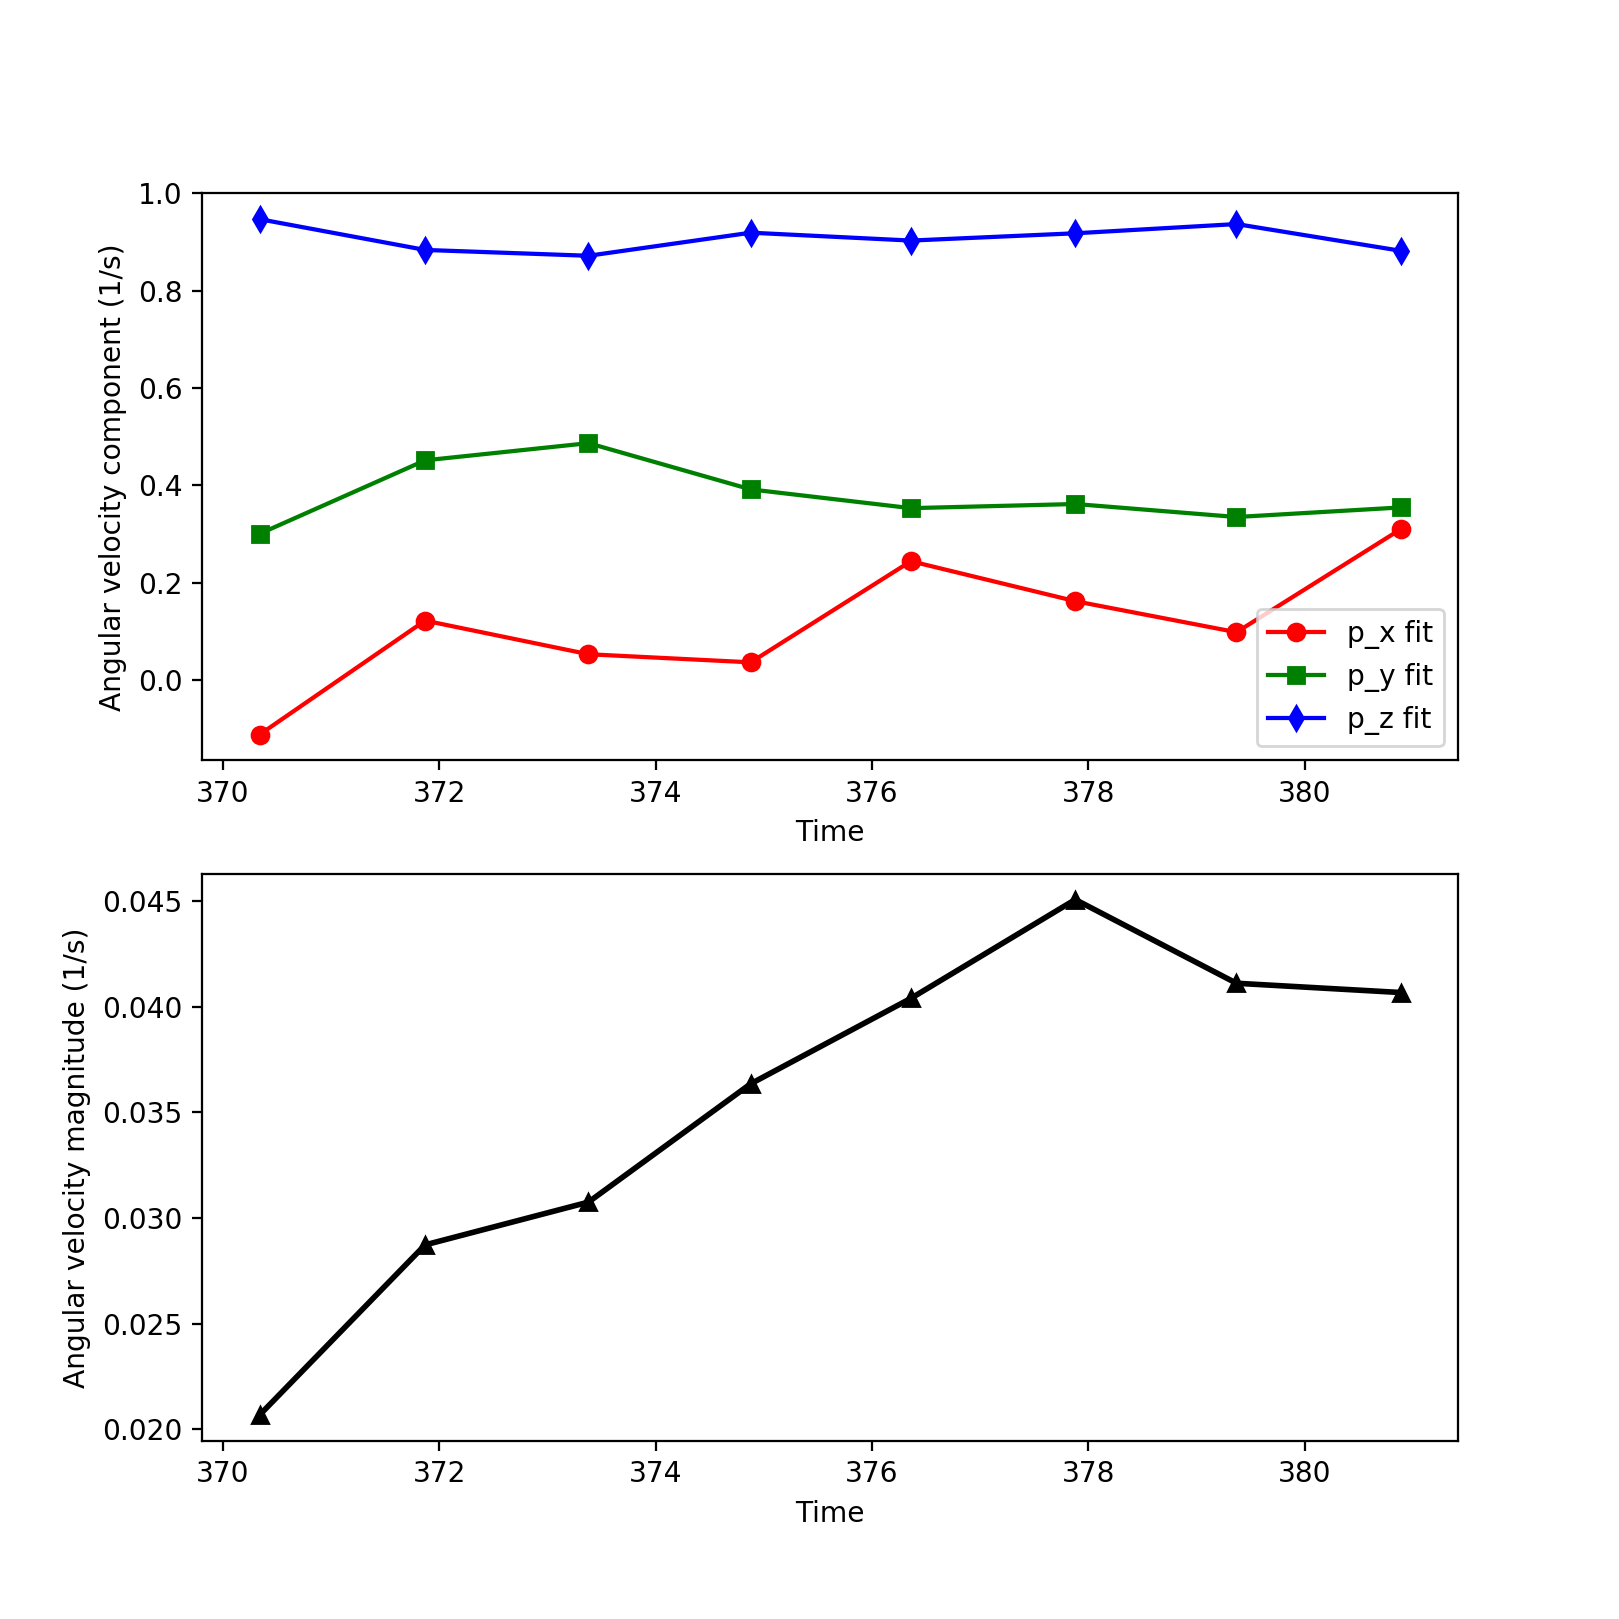

Mean angular velocity: 0.03547470311606831 1/s
Stdev in angular velocity: 0.007611306028300933 1/s


In [268]:
# Plot the fitting results vs time

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))

ax1.plot(time_vect[window_centers], angular_velocity_fit[0,:]/angular_velocity_fit_mag, color = 'r', marker = 'o', label = 'p_x fit' )
ax1.plot(time_vect[window_centers], angular_velocity_fit[1,:]/angular_velocity_fit_mag, color = 'g', marker = 's',label = 'p_y fit' )
ax1.plot(time_vect[window_centers], angular_velocity_fit[2,:]/angular_velocity_fit_mag, color = 'b', marker = 'd',label = 'p_z fit' )

ax1.set_xlabel('Time')
ax1.set_ylabel('Angular velocity component (1/s)')
ax1.legend(loc ='best')

ax2.plot(time_vect[window_centers], angular_velocity_fit_mag, marker = '^', color = 'k', linewidth = 2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Angular velocity magnitude (1/s)')

# plt.savefig(test_image_folder+ '_'+str(nTracks)+'_AngularVelocity_time_series.png', dpi = 300)
plt.show()

# Print the results
omega_fit_mean = np.nanmean(angular_velocity_fit_mag)
omega_fit_std = np.nanstd(angular_velocity_fit_mag)
print('Mean angular velocity: {} 1/s'.format(omega_fit_mean))
print('Stdev in angular velocity: {} 1/s'.format(omega_fit_std))

<IPython.core.display.Javascript object>


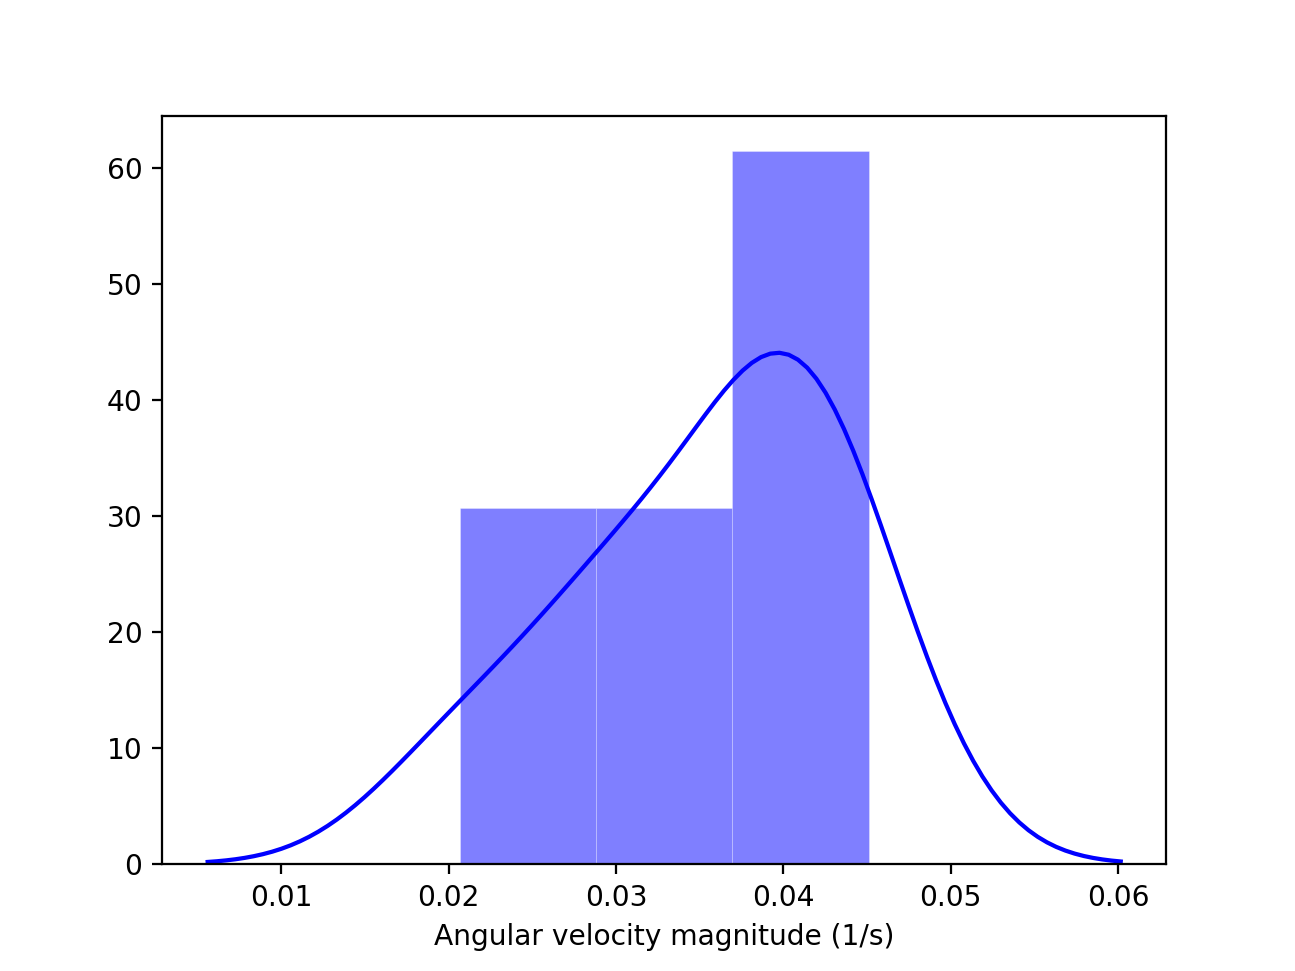

In [269]:
# Plot a histogram of the angular velocity magnitudes for the track segments
import seaborn as sns

plt.figure()
ax0 = sns.distplot(angular_velocity_fit_mag,  kde = True , color = 'b', norm_hist = True, hist_kws={"histtype": "bar","edgecolor":'w', "linewidth": 0.2, "alpha": 0.5, "label":'Vz'})
plt.xlabel('Angular velocity magnitude (1/s)')
# plt.savefig(df['track ID'][0]+'_'+'AngularSpeedDist_{}'.format(window_size))
plt.show()

# Calculate relative error for testing data

In [423]:
# Calculate the relative error in the fit
rel_error = np.zeros(nWindows)
rel_error_mag = np.zeros(nWindows)
angular_vel_mag = np.zeros(nWindows)

for index in range(nWindows):
    vect = angular_velocity_fit[:, index]
    angular_vel_mag[index] = (np.sum((vect)**2))**(1/2)
    rel_error_mag[index] = 100*abs(angular_vel_mag[index] - omega_true)/omega_true
    rel_error[index] = 100*(np.sum((angular_velocity_fit[:, index] - omega_vect_true)**2)/np.sum((omega_vect_true)**2))**(1/2)

# Plots for testing

<IPython.core.display.Javascript object>


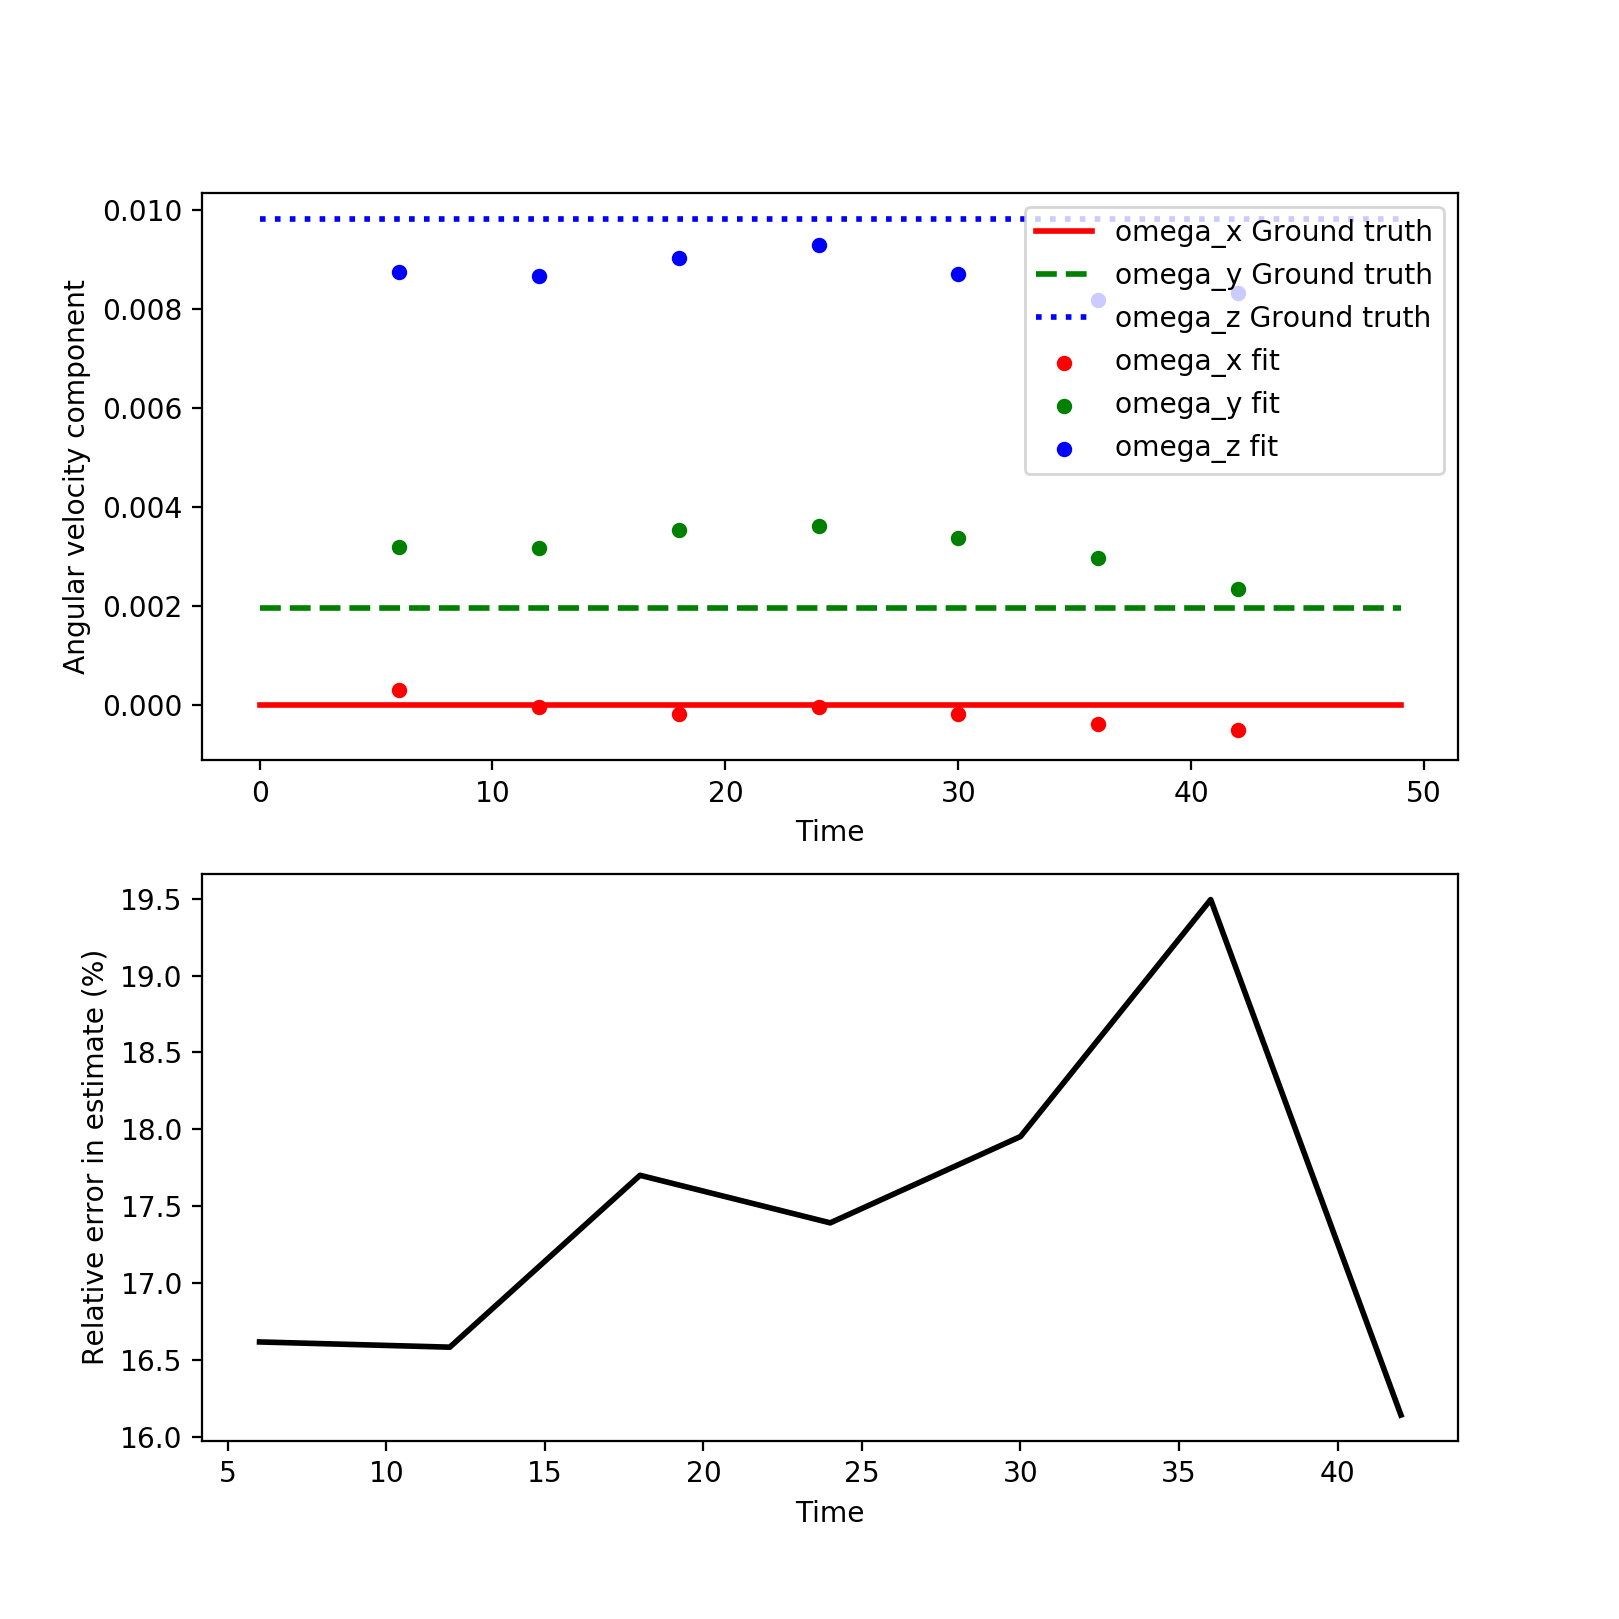

In [424]:
# (FOR TESTING) Plot the angular velocity fit vs the true angular velocity

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))

ax1.plot(time_vect, np.repeat(omega_vect_true[0], len(time_vect)), 'r', linewidth = 2, label = 'omega_x Ground truth')
ax1.plot(time_vect, np.repeat(omega_vect_true[1], len(time_vect)), 'g', linewidth = 2, label = 'omega_y Ground truth')
ax1.plot(time_vect, np.repeat(omega_vect_true[2], len(time_vect)), 'b', linewidth = 2, label = 'omega_z Ground truth')

ax1.scatter(time_vect[window_centers], angular_velocity_fit[0,:], 20, color = 'r', label = 'omega_x fit' )
ax1.scatter(time_vect[window_centers], angular_velocity_fit[1,:], 20, color = 'g', label = 'omega_y fit' )
ax1.scatter(time_vect[window_centers], angular_velocity_fit[2,:], 20, color = 'b', label = 'omega_z fit' )

ax1.set_xlabel('Time')
ax1.set_ylabel('Angular velocity component')
ax1.legend(loc ='best')

ax2.plot(time_vect[window_centers], rel_error, 'k', linewidth = 2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Relative error in estimate (%)')

plt.savefig(test_image_folder+ '_'+str(nTracks)+'_FitvsActual_AngularVelocity.png', dpi = 300)
plt.show()

In [425]:
print(angular_vel_mag)
print(omega_true)
print(rel_error)
print(rel_error_mag)

[0.00930365 0.00922632 0.00969394 0.00996887 0.00933412 0.00871433
 0.00865998]
0.01
[16.61819546 16.58426069 17.70164915 17.39241653 17.95355504 19.4941229
 16.14311491]
[ 6.96354072  7.7368207   3.06062601  0.31125035  6.65880971 12.8566908
 13.40019766]


In [310]:
print(folder)
print('Least-squares solution (Fit velocity): {}'.format(least_sq_soln_fit_velocity))
print('Least-squares solution (True velocity): {}'.format(least_sq_soln_true_velocity))
print('Actual solution: {}'.format(omega_vect_true))

omega_fit = np.sum(least_sq_soln_fit_velocity**2)**(1/2)

print('Predicted angular speed (fit): {}'.format(omega_fit))
print('True angular speed: {}'.format(omega_true))
print('Relative error in angular speed: {}(%)'.format(100*abs(omega_fit-omega_true)/omega_true))

orient_vect_fit = -least_sq_soln_fit_velocity/omega_fit

print('Predicted angular velocity orientation: {}'.format(orient_vect_fit))

print('True angular velocity orientation: {}'.format([p_x_true, p_y_true, p_z_true]))

# Error in orientation vector
orient_vect_error = (np.sum((orient_vect_true - orient_vect_fit)**2))**(1/2)
orient_vect_mag = (np.sum(orient_vect_true**2))**(1/2)
      
print('Relative error in orientation vector: {}%'.format(100*orient_vect_error/orient_vect_mag))

C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images2020-12-08 01-27
Least-squares solution (Fit velocity): [-0.00021609  0.00024969 -0.01073471]
Least-squares solution (True velocity): [-5.42101086e-20 -6.50521303e-19  1.00000000e-02]
Actual solution: [0.   0.   0.01]
Predicted angular speed (fit): 0.010739784844034584
True angular speed: 0.01
Relative error in angular speed: 7.397848440345839(%)
Predicted angular velocity orientation: [ 0.02012019 -0.02324896  0.99952722]
True angular velocity orientation: [0.0, 0.0, 1.0]
Relative error in orientation vector: 3.0749955218227214%


<IPython.core.display.Javascript object>


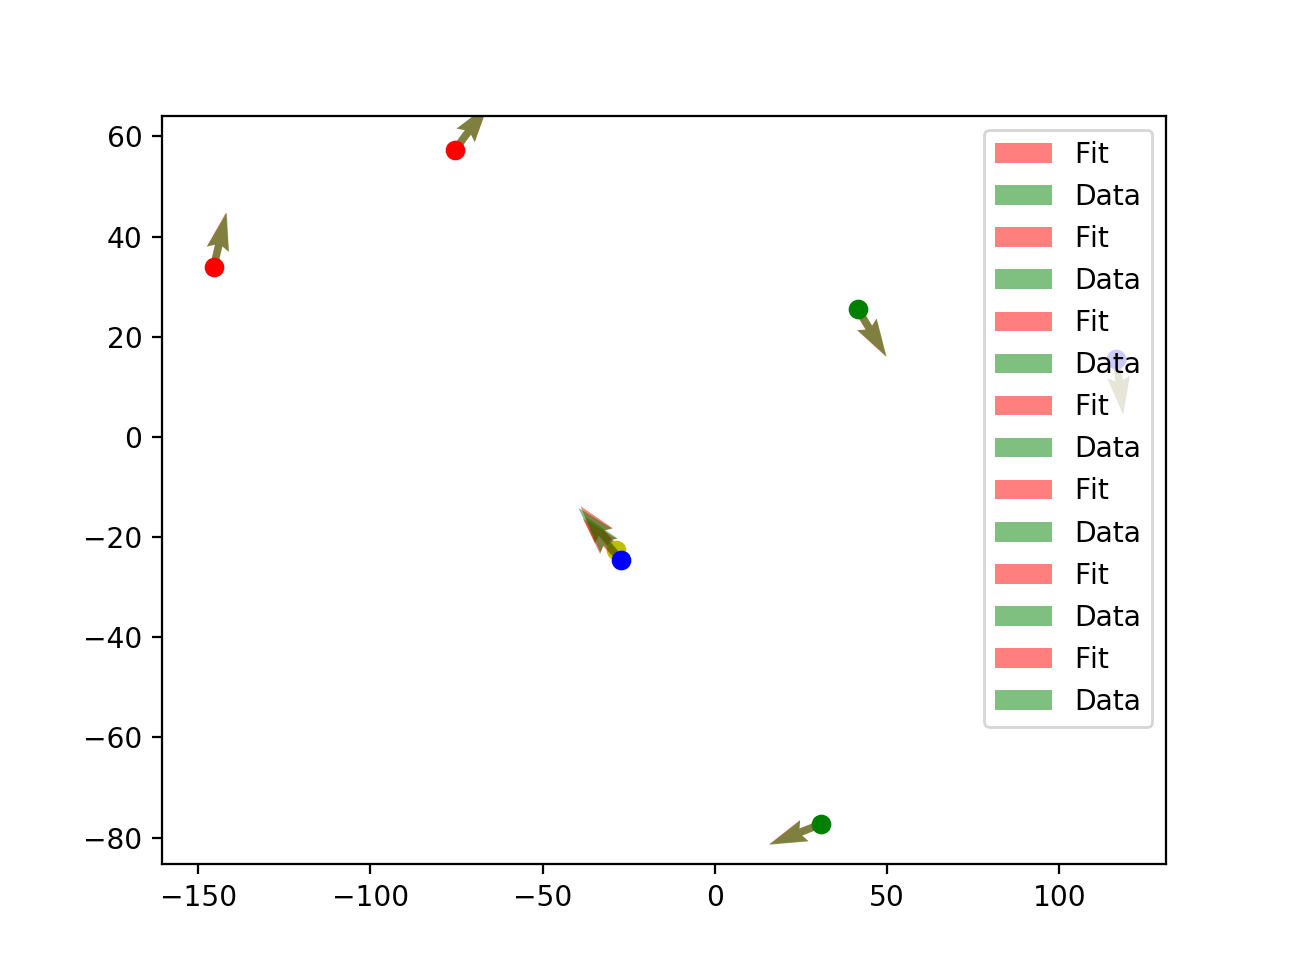

In [241]:
# Calculate the translational velocity by applying a rotation matrix based on the predicted angular velocity vector
velocity_vect_fit_x = {}
velocity_vect_fit_z = {}

for ii in range(nTracks):
    r_x, r_y, r_z = init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]
    
    r_init = np.array([r_x, r_y, r_z])
    
    v = np.cross(least_sq_soln_fit_velocity, r_init, axisa = 0, axisb = 0)
    
    velocity_vect_fit_x[ii] = v[0]
    velocity_vect_fit_z[ii] = v[2]
    

plt.figure()

for ii in range(nTracks):
    
    plt.quiver(init_pos_x[ii], init_pos_z[ii], velocity_vect_fit_x[ii], velocity_vect_fit_z[ii], color = 'r', label = 'Fit', alpha =0.5)
    plt.quiver(init_pos_x[ii], init_pos_z[ii], centroids_velocity_x[ii], centroids_velocity_z[ii], color = 'g', label = 'Data', alpha =0.5)
#     plt.quiver(init_pos_x[ii], init_pos_z[ii], v_true[ii][0], v_true[ii][2], color = 'b', label = 'True', alpha =0.5)

    plt.scatter(init_pos_x[ii], init_pos_z[ii])
    

plt.legend()
plt.show()


<IPython.core.display.Javascript object>


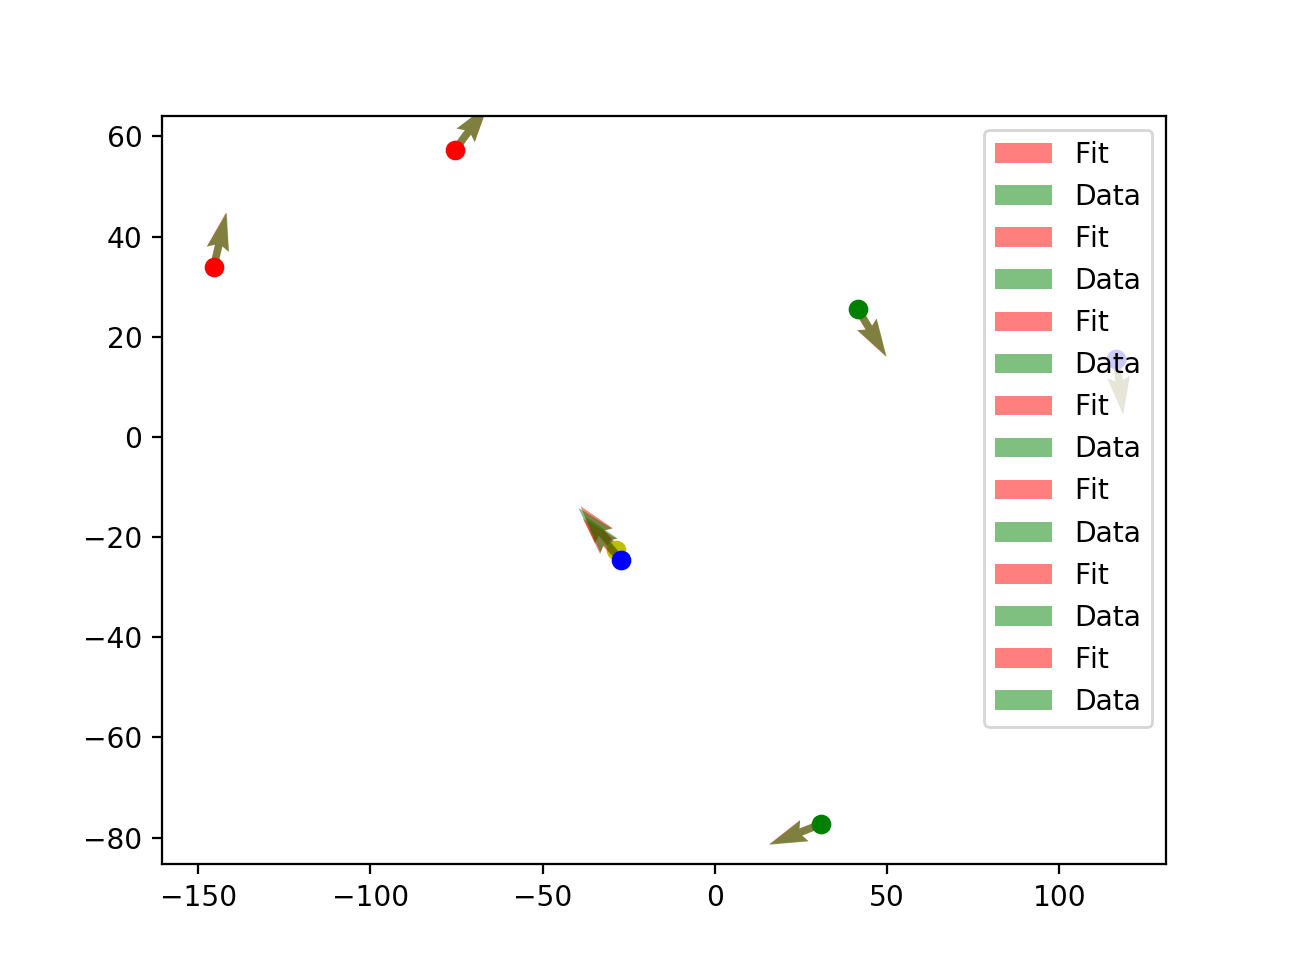

<IPython.core.display.Javascript object>


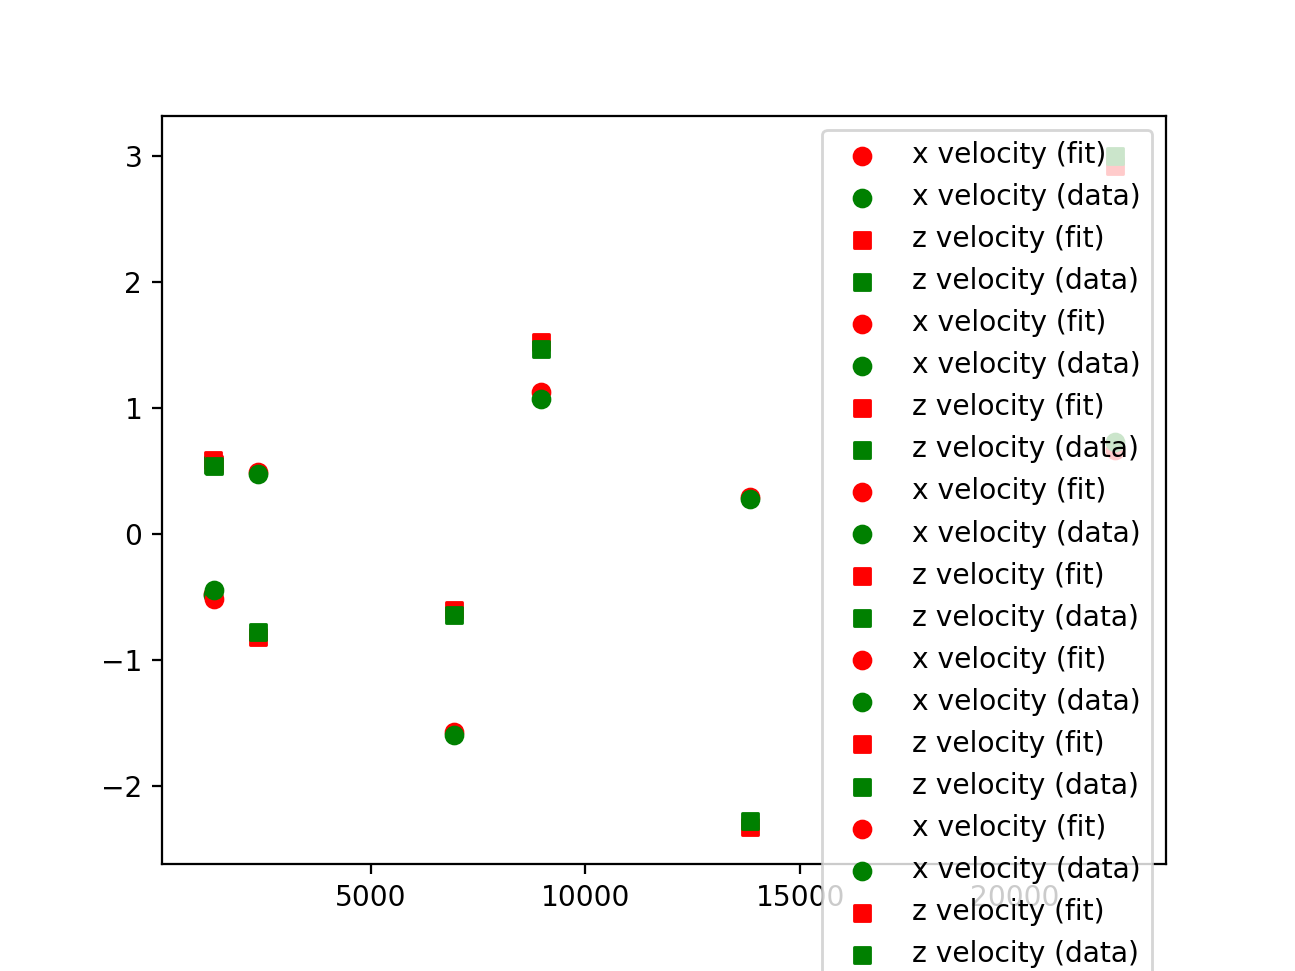

<IPython.core.display.Javascript object>


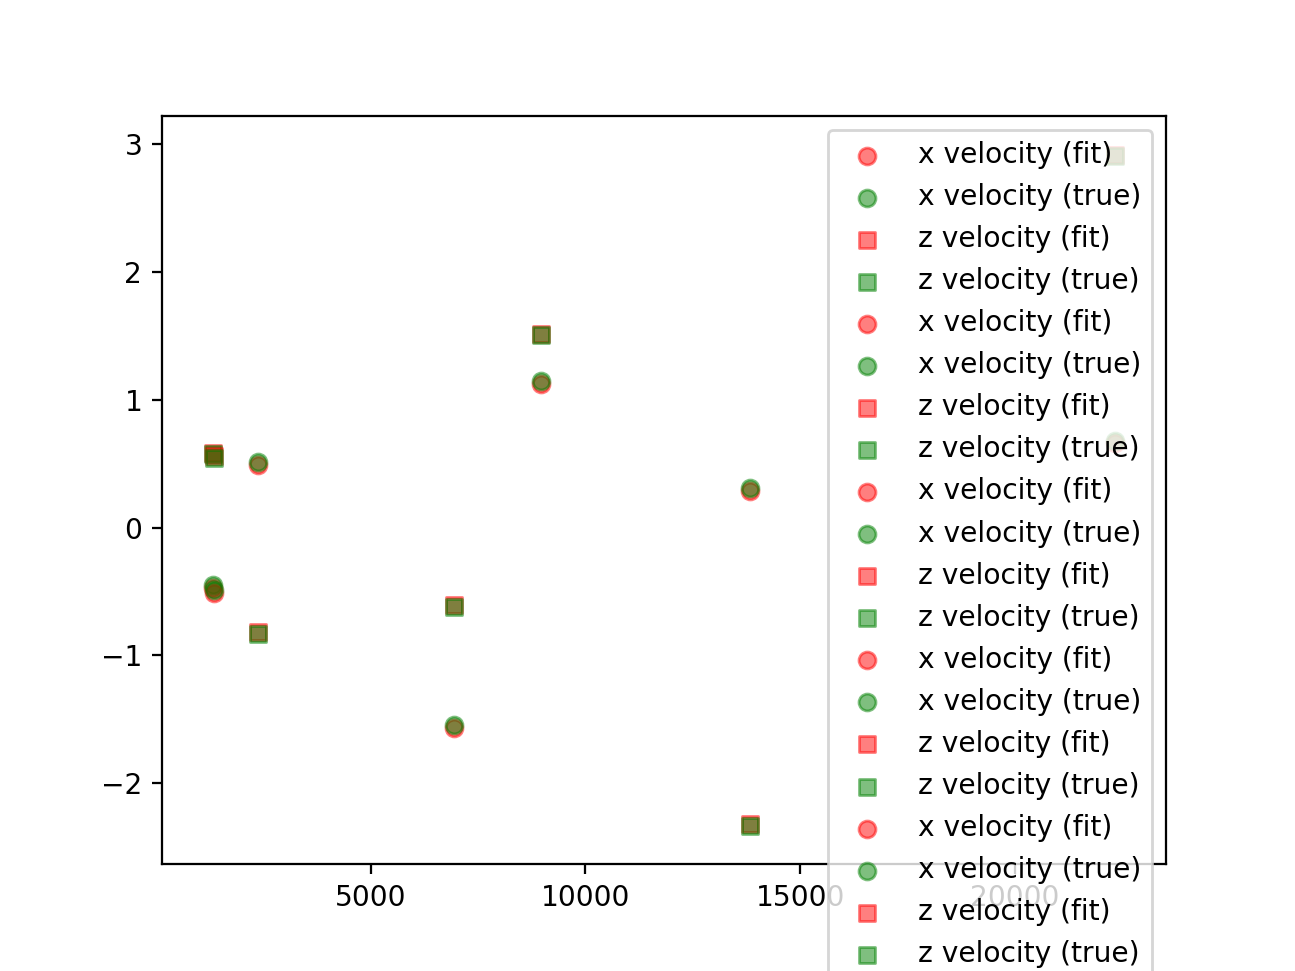

In [242]:
# Predicted translational velocities based on angular velocity fit
velocity_vect_fit = np.matmul(matrix_A, least_sq_soln_fit_velocity)

plt.figure()

for ii in range(nTracks):
    
    plt.quiver(init_pos_x[ii], init_pos_z[ii], velocity_vect_fit[2*ii], velocity_vect_fit[2*ii+1], color = 'r', label = 'Fit', alpha =0.5)
    plt.quiver(init_pos_x[ii], init_pos_z[ii], centroids_velocity_x[ii], centroids_velocity_z[ii], color = 'g', label = 'Data', alpha =0.5)

    plt.scatter(init_pos_x[ii], init_pos_z[ii])
    

plt.legend()
plt.show()

plt.figure()

for ii in range(nTracks):
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii], marker = 'o',label='x velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, centroids_velocity_x[ii], marker = 'o', label='x velocity (data)', color = 'g')
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii+1], marker = 's',label='z velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, centroids_velocity_z[ii], marker = 's', label='z velocity (data)', color = 'g')
    

plt.legend(loc='best')
plt.show()

plt.figure()

for ii in range(nTracks):
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii], alpha = 0.5, marker = 'o',label='x velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, v_true[ii][0], alpha = 0.5, marker = 'o', label='x velocity (true)', color = 'g')
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii+1], alpha = 0.5, marker = 's',label='z velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, v_true[ii][2],alpha = 0.5, marker = 's', label='z velocity (true)', color = 'g')
    

plt.legend(loc='best')
plt.show()


# Trajectory-based fitting

In [107]:
# Generate the data for the fitting (trajectory of centroids relative to the sphere center)

data = []


for ii in range(nTracks):
    r_x, r_z = centroids_x[ii], centroids_z[ii]
    
    data = np.concatenate((data, r_x[1:], r_z[1:]), axis = None)  # Exclude the first point since it's used as an initial condition for the model


print(data.shape)

(480,)


{0: -146.50241088867188, 1: -116.9710693359375, 2: -75.49198913574219, 3: 113.5128173828125, 4: 39.495452880859375}
{0: 168.26475487905583, 1: 93.63717930690325, 2: 205.70408429854467, 3: 190.99326367284135, 4: 208.41360428875495}
{0: 20.000396728515625, 1: -166.51080322265625, 2: 46.50579833984375, 3: 28.50286865234375, 4: -71.97137451171875}


28299.0

In [109]:
# Checking with known parameter values
# setup the "Model" (rotation about an arbitrary axis)

from scipy.spatial.transform import Rotation as R


omega_vect = 0.02*np.array([0,1,0]) 
time_diff = np.ones(nTimepoints-1)

r = R.from_rotvec(omega_vect)

model = []

pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


for ii in init_pos_x.keys():

    r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

    for jj, delta_t in enumerate(time_diff):

        if(jj == 0):
            pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
        else:
            pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


    r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

    model = np.concatenate((model, r_x_model, r_z_model), axis = None)
    
print(model.shape)
print(data.shape)

(480,)
(480,)


<IPython.core.display.Javascript object>


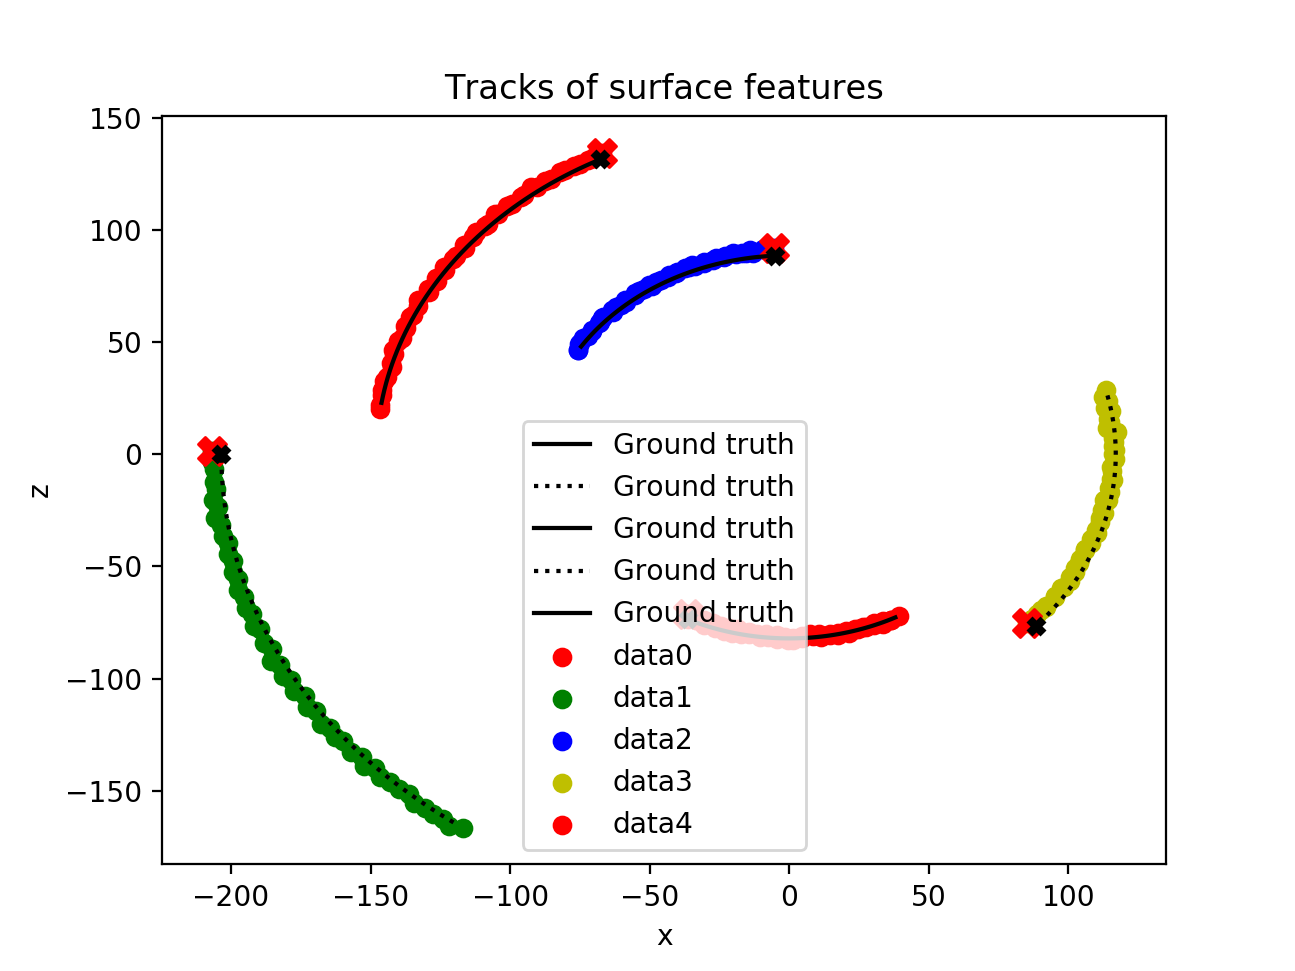

In [110]:
# Print data vs known parameter
plt.figure()

for ii in range(nTracks):
    
    plt.scatter(centroids_x[ii], centroids_z[ii], label = 'data' +str(ii))
    plt.plot(pos_array[ii][0,:], pos_array[ii][2,:], color = 'k', label = 'Ground truth')
    plt.plot(pos_array[ii][0,-1], pos_array[ii][2,-1], color = 'k', marker = 'X')
    plt.scatter(centroids_x[ii][-1], centroids_z[ii][-1], 100, marker = 'X', color = 'r')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Tracks of surface features')
plt.legend()
plt.show()

In [122]:
# Setup the problem to perform least-sq fitting of the trajectory.

from lmfit import Minimizer, Parameters, fit_report


def residual(params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = None):
    
    omega_vect = np.array([0, params['omega_y'], params['omega_z']])    

    r = R.from_rotvec(omega_vect)

    model = []

    pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


    for ii in init_pos_x.keys():

        r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

        for jj, delta_t in enumerate(time_diff):

            if(jj == 0):
                pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
            else:
                pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


        r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

        model = np.concatenate((model, r_x_model, r_z_model), axis = None)
            
        
    
    return model - data

time_diff = np.ones(nTimepoints-1)

# orient_vect = [0,1,0]

fit_params = Parameters()
fit_params.add(name = 'omega_y', value= 0.2, min=0.0, max=0.5)
fit_params.add(name = 'omega_z', value= 0.0, min=0.0, max=0.5)


# Setup the least-squares problem
fit = Minimizer(residual, fit_params, fcn_args=(init_pos_x, init_pos_y, init_pos_z, time_diff,), fcn_kws={'data': data},scale_covar=True)
fit.minimize(method = 'leastsq')

result = fit.leastsq()
init = residual(fit_params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)
fit = residual(result.params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)

result.params
# out = minimize(residual, fit_params, args=(init_pos_x, init_pos_y, init_pos_z, time_diff,), kws={'data': data}, method = 'cg')
# print(fit_report(out))

name,value,standard error,relative error,initial value,min,max,vary
omega_y,0.20000000,0.00228206,(1.14%),0.2,0.00000000,0.50000000,True
omega_z,0.00000000,3.7117e-11,(inf%),0.0,0.00000000,0.50000000,True


name,value,standard error,relative error,initial value,min,max,vary
omega_y,0.02008733,1.9644e-05,(0.10%),0.05,0.00000000,0.20000000,True
omega_z,2.7898e-04,1.5292e-05,(5.48%),0.05,0.00000000,0.20000000,True


In [115]:
# Plot the residual as a function of the parameters
def residual_func(p_y, p_z, init_pos_x, init_pos_y, init_pos_z, time_diff, data = None):
    
    omega_vect = np.array([0, p_y, p_z])    

    r = R.from_rotvec(omega_vect)

    model = []

    pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


    for ii in init_pos_x.keys():

        r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

        for jj, delta_t in enumerate(time_diff):

            if(jj == 0):
                pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
            else:
                pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


        r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

        model = np.concatenate((model, r_x_model, r_z_model), axis = None)
            
        
    
    return np.sum((model - data)**2)
    

# Make a 2D array for the parameter-space

p_y_array = np.arange(0, 0.5, 0.01)
p_z_array = np.arange(0, 0.5, 0.01)
p_y_matrix, p_z_matrix = np.meshgrid(p_y_array, p_z_array)

residual_array = np.zeros_like(p_y_matrix)

print(residual_array.shape)
for ii in range(len(p_y_array)):
    
    for jj in range(len(p_z_array)):
        
        residual_array[ii,jj] = residual_func(p_y_matrix[ii,jj], p_z_matrix[ii,jj], init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)
        

        
        

(50, 50)


<IPython.core.display.Javascript object>


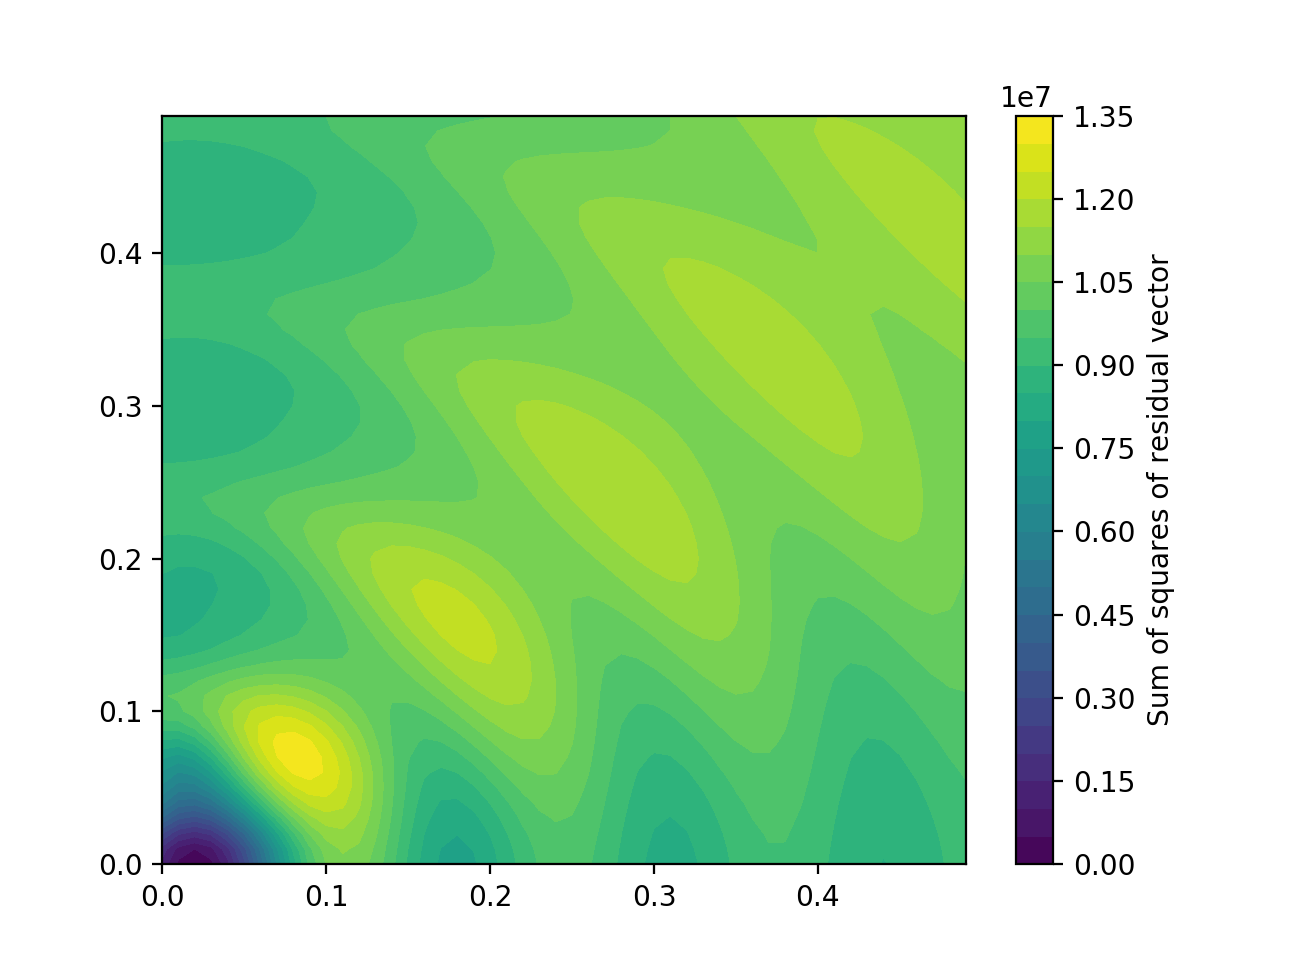

In [116]:
# Plot the residual as a function of the parameter space

plt.figure()
CS = plt.contourf(p_y_array,p_z_array,residual_array, levels = 30)
fig = plt.gcf()
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Sum of squares of residual vector')
plt.savefig('Residual contours vs fitting params_5tracks.png', dpi = 300)
plt.show()

name,value,initial value,min,max,vary
r_init,-inf,None,-inf,inf,False
omega,1.00000000,None,-inf,inf,True
p_x,1.00000000,None,-inf,inf,True
p_y,1.00000000,None,-inf,inf,True
p_z,1.00000000,None,-inf,inf,True


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [315]:
K = 4 # K should be even
window_centers = np.array(range(int(K/2), nTimepoints-int(K/2), int(K/2)))

In [316]:
window_centers

array([2, 4, 6, 8])

In [319]:
window_edges

[[0, 4], [2, 6], [4, 8], [6, 10]]

In [322]:
window_slice = []
for index in window_edges:
    window_slice.append(centroids_x[0][index[0]:index[1]])

In [323]:
window_slice

[array([-12.49832153, -11.51101685, -10.52038574,  -9.5166626 ]),
 array([-10.52038574,  -9.5166626 ,  -7.52407837,  -6.49008179]),
 array([-7.52407837, -6.49008179, -5.52676392, -4.62435913]),
 array([-5.52676392, -4.62435913, -3.66607666, -3.71411133])]